In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MLP Klassifikation

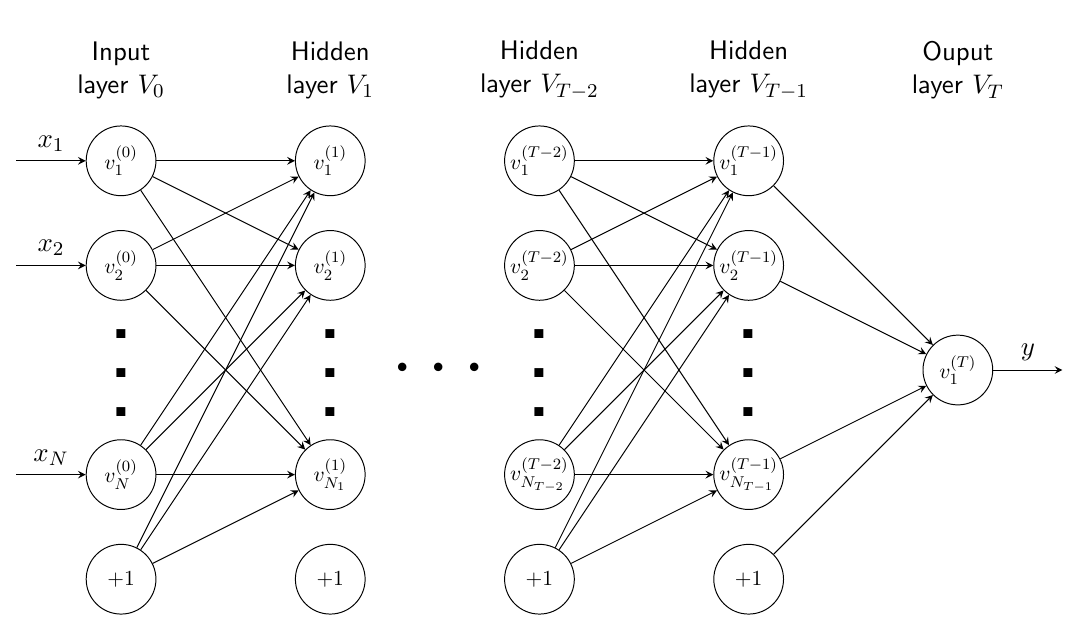

\begin{align}
\begin{split}
a^{(0)} &= \sigma^{(0)}(x) \\
a^{(1)} &= \sigma^{(1)}(W^{(1)}a^{(0)} + b^{(1)}) \\
a^{(2)} &= \sigma^{(2)}(W^{(2)}a^{(1)} + b^{(2)}) \\
\hat y = a^{(3)} &= \sigma^{(3)}(W^{(3)}a^{(2)} + b^{(3)}).
\end{split}
\end{align}

Oder durch Verschachtelung können wir es schreiben als
\begin{equation}
\hat y = a^{(3)} = \sigma^{(3)}(W^{(3)} \sigma^{(2)}(W^{(2)} \sigma^{(1)}(W^{(1)}\sigma^{(0)}(x) + b^{(1)}) + b^{(2)}) + b^{(3)}).
\end{equation}

Für ein neuronales Netz $f_{\hat W}$ ist das empirische Risiko durch den Durchschnitt der Verlustfunktion $L$ gegeben
\begin{equation}
\mathcal{L}_{NN} = \frac{1}{m} \sum_{k=1}^m L\left(f_{\hat W}(x_k), y_k\right).
\end{equation}

Wir wollen herausfinden, wie empfindlich das Risiko in Bezug auf ein bestimmtes Gewicht ist, d.h. was ist die Ableitung von $\mathcal{L}_{NN}$ in Bezug auf das Gewicht $w^{(t)}_{ij}$, das das $j$<sup>th</sup> Neuron in Layer $t-1$ mit dem $i$<sup>th</sup> Neuron in Layer $t$ verbindet, d.h., 

\begin{equation}\label{eq:grad_risk}
\frac{\partial \mathcal{L}_{NN}}{\partial w_{ij}^{(t)}} = \frac{1}{m} \sum_{k=1}^m \frac{\partial L(f_{\hat W}(x_k), y_k)}{\partial w_{ij}^{(t)}}.  
\end{equation}


Wie zuvor bezeichnen wir die Ausgabe der affinen Transformation mit $z^{(t)} = W^{(t)}a^{(t-1)} + b^{(t)}$ und die Aktivierung mit $a^{(t)} = \sigma^{(t)}(z^{(t)})$.
Für eine Trainingsstichprobe $(x,y)$ leiten wir dann mit der Kettenregel ab
\begin{equation}\label{eq:backprop}
\frac{\partial L(a^{(T)}, y)}{\partial w_{ij}^{(t)}} =
\frac{\partial L(a^{(T)}(x), y)}{\partial a^{(t)}}
\frac{\partial a^{(t)}}{\partial z^{(t)}}
\frac{\partial z^{(t)}}{\partial w_{ij}^{(t)}}.
\end{equation}
Man beachte hier, dass für Layer $t$ mit $N_t$ Neuronen der erste Term die $1 \times N_t$ Jacobimatrix des Verlustes ist, der zweite Term ist eine $N_t \times N_t$ Diagonalmatrix, deren $i$<sup>th</sup> diagonaler Eintrag die Ableitung der Aktivierungsfunktion ${(\sigma_i^{(t)}}(z^{(t)}_i))'$ ist und der letzte Term ist einfach der Nullvektor der Größe $N_t$, dessen $i$<sup>th</sup> Eintrag auf $z^{(t)}_j$ gesetzt ist.  Wenn wir die Ableitung nach einem Gewicht $b^{(t)}_i$ im Abfangterm $b^{(t)}$ nehmen, ändert sich nicht viel. Der einzige Unterschied ist, dass der letzte Term $1$ als $i$<sup>th</sup> Eintrag enthält. 

Deep Learning Libraries bestehen essentiell aus einem Linear Algebra Packet mit Unterstützung fürs Automatische Differenzieren und GPUs, TPUs. Wir verwenden `Tensorflow` und `Keras`, weil es besonders anfängerfreundlich ist. Es gibt aber auch andere beliebte Python Packete fürs *Deep Learning*, wie `Theano`, [JAX](https://github.com/google/jax), [PyTorch](https://pytorch.org/docs/stable/index.html) usw.



In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)
tf.config.list_physical_devices('GPU')

2.9.1
2.9.0


[]

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full.shape

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-labels-idx1-ubyte.gz: None -- [Errno 11001] getaddrinfo failed

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
X_test.shape

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", 
                       show_shapes=True)

In [ ]:
hidden1 = model.layers[1]
print("hidden1.name:", hidden1.name)

# we can get and set the weights for each layer
weights, biases = hidden1.get_weights()
hidden1.set_weights([weights, biases])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_new = X_test[:3]
y_new = y_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
print("true:", np.array(class_names)[y_new])
print("predict:", np.array(class_names)[y_pred])
print(y_pred)

## Klassifikation mit Convolutional Neuronales Netzwerk

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input([28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(20, 3, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, 3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(10, 3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

In [ ]:
model.save("my_keras_model.h5")

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

# Regression with Hyperparameter Tuning

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:

def build_model(n_hidden=1, n_neurons=30, 
                learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
X_new = X_test[:3]

mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)
print("score on testset", mse_test)
print(y_pred)

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=50, verbose=0,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

# Autoencoders

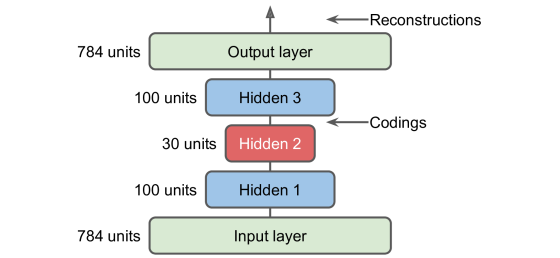

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

tf.random.set_seed(42)
np.random.seed(42)

NameError: name 'fashion_mnist' is not defined

In [ ]:
#encoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(30, activation="selu"),
])
#decoder
stacked_decoder = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse",
                   optimizer=keras.optimizers.Nadam(), metrics=['mse'])
history = stacked_ae.fit(X_train, X_train, epochs=100, verbose=2,
                         validation_data=(X_valid, X_valid))

In [ ]:
# def vae_loss(x, x_decoded_mean, z_log_var, z_mean,original_dim=28*28):
#     xent_loss = original_dim * objectives.binary_crossentropy(
#     x, x_decoded_mean)
#     kl_loss = - 0.5 * K.sum(
#     1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
#     axis=-1)
#     return xent_loss + kl_loss
# vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() 
                                                - X_valid_2D.min())

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 
            c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()